In [53]:
from glob import glob
pathes = glob("/kaggle/input/imagenetmini-1000/imagenet-mini/train//**/*.JPEG", recursive=True)
print(len(pathes))

34745


In [115]:
import os
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image
from glob import glob

class InpaintingDataset(Dataset):
    def __init__(self, root_dir, transform=None, mask_size=100, n_masks=1):
        """
        Dataset for image inpainting.

        Args:
        - root_dir (str): Root directory containing images.
        - transform (callable, optional): A function/transform to apply to the images.
        - mask_size (int, optional): Size of the square mask to apply.
        - n_masks (int, optional): Number of masks to apply per image.
        """
        self.image_paths = glob(root_dir + "/**/*.JPEG", recursive=True)
        self.transform = transform
        self.mask_size = mask_size
        self.n_masks = n_masks

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        """
        Get a sample from the dataset.

        Args:
        - index (int): Index of the sample to retrieve.

        Returns:
        - image (Tensor): Original image.
        - masked_img (Tensor): Image with random masks applied.
        - mask (Tensor): Binary mask indicating masked regions.
        - mask_region (Tensor): Coordinates of the mask regions.
        """
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        masked_img, mask, mask_region = self.apply_random_mask(image, self.n_masks)

        return image, masked_img, mask, mask_region
    
    def apply_random_mask(self, img, n_masks=1):
        """
        Apply random masks to the input image.

        Args:
        - img (Tensor): Input image.
        - n_masks (int, optional): Number of masks to apply.

        Returns:
        - masked_img (Tensor): Image with random masks applied.
        - mask (Tensor): Binary mask indicating masked regions.
        - mask_region (Tensor): Coordinates of the mask regions.
        """
        masked_img = img.clone()
        fill_value = masked_img.mean()
        mask = torch.zeros(masked_img.shape)
        
        y1 = torch.randint(0, masked_img.shape[1] - self.mask_size, (n_masks, ))
        x1 = torch.randint(0, masked_img.shape[2] - self.mask_size, (n_masks, ))
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        
        for i in range(n_masks):
            masked_img[:, y1[i]:y2[i], x1[i]:x2[i]] = fill_value
            mask[:, y1[i]:y2[i], x1[i]:x2[i]] = 1
        
        return masked_img, mask, torch.stack((y1, x1), axis=1)

In [116]:
root_dir = "/kaggle/input/imagenetmini-1000/imagenet-mini/train"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = InpaintingDataset(root_dir, transform, mask_size=50, n_masks=2)
len(dataset)

34745

In [128]:
image, masked_img, mask, masks_coords = dataset[0]
image.shape, masked_img.shape, mask.shape, masks_coords.shape

(torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([3, 256, 256]),
 torch.Size([2, 2]))

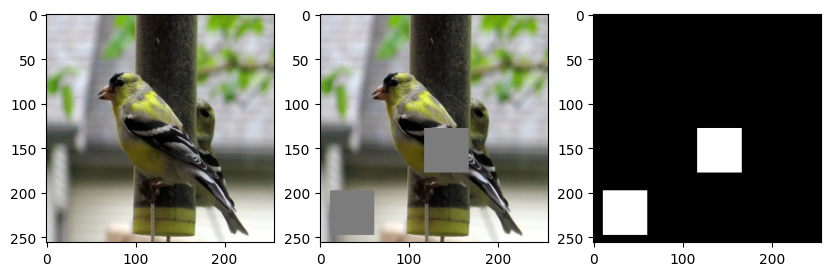

In [131]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image.permute(1, 2, 0).numpy())
plt.subplot(1, 3, 2)
plt.imshow(masked_img.permute(1, 2, 0).numpy())
plt.subplot(1, 3, 3)
plt.imshow(mask.permute(1, 2, 0).numpy())

In [129]:
def get_masked_region(image, masks_coords, mask_size):
    """
    Extract masked regions from the input image based on the provided coordinates.

    Args:
    - image (Tensor): Input image.
    - masks_coords (Tensor): Coordinates of the masked regions.
    - mask_size (int): Size of the square mask.

    Returns:
    - regions (list): List of masked regions extracted from the image.
    """
    regions = []
    for y1, x1 in masks_coords:
        regions.append(image[:, y1:y1+mask_size, x1:x1+mask_size])
    return regions

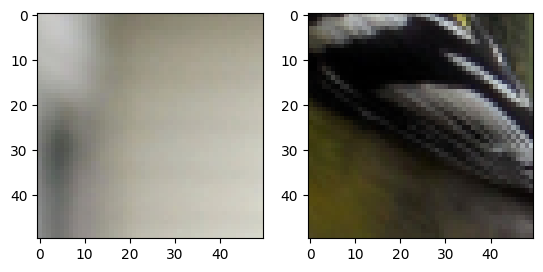

In [130]:
regions = get_masked_region(image, masks_coords, 50)
for i in range(len(regions)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(regions[i].permute(1, 2, 0).numpy())